In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

"""
Regression Model
"""
class StateSpaceRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, exog, initialization, initial_state=None, initial_state_cov=None):
        # Model order
        # k_state:  状態の次元
        # k_posdef: 過程誤差分散行列の次元
        k_states = k_posdef = 2

        # Initialize the statespace
        super(StateSpaceRegression, self).__init__(
            endog, exog=exog, k_states=k_states, k_posdef=k_posdef,
            initialization=initialization, initial_state=initial_state, initial_state_cov=initial_state_cov,
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        # 時間変化するdesign matirxで説明変数を表す。
        n_obs = len(exog)
        self.ssm['design'] = np.vstack((np.repeat(1, n_obs), exog))[np.newaxis, :, :]
        
        self.ssm['transition'] = self.ssm['selection'] = np.eye(k_states)

        # updateでself.ssmにstate_covの値をセットするために用いる
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.intercept', 'sigma2.coefficient']

    @property
    #  パラメータの最尤推定の際の初期値
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(StateSpaceRegression, self).update(params, *args, **kwargs)
        
        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

1. k_state, k_posdef: 状態ベクトルと過程誤差分散行列の次元。目的変数（観測値）の次元はデータから推測されるので与える必要がない。
2. update: fitメソッドでパラメータを最尤推定する際に用いられる。パラメータを受け取り、適切な状態空間行列を設定する。
3. statespace matrices: デフォルトでは全ての行列がゼロ行列となっている。単位行列でないことに注意。時間変化する場合はupdateメソッドで設定する必要がある。self.ssmに格納されている。
4. start params: 分散パラメータの最尤推定の際の初期値
5. initialization: 状態ベクトルの初期分布の平均値と分散を設定する必要がある。初期分布が既知の場合はinitialize_known、不明の場合はinitialize_approximate_diffuse(近似的な散漫初期化)を用いる。

6. transform: デフォルトでは制約なしでパラメータ推定が行われるが、transform_paramsを設定することで、正値をとる分散のように制約付きのパラメータに変換することができる。
7. param_names: 推定するパラメータに名前をつけられる。

## simulation data

In [83]:
from numpy import random

T = 100
seed = 42

# error term
sig_level = 0.1

# initial state
mu_zero = 1.0
beta_zero = 0.8

random.seed(seed)
random.rand()

# exogenous varables




0.3745401188473625

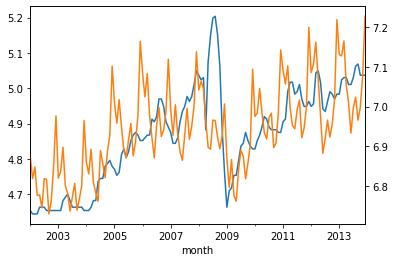

In [79]:
df = pd.read_csv('data/sales_gasoline.csv', parse_dates=[0], index_col=0)
exog, endog = np.log(df.Fuel), np.log(df.Gasoline)

ax = endog.plot()
exog.plot(ax=ax, secondary_y=True)

## 任天堂、日経

In [19]:
nintendo = pd.read_csv('data/NINTENDO.csv', index_col=0, parse_dates=[0])
nikkei = pd.read_csv('data/NIKKEI225.csv', index_col=0, parse_dates=[0])

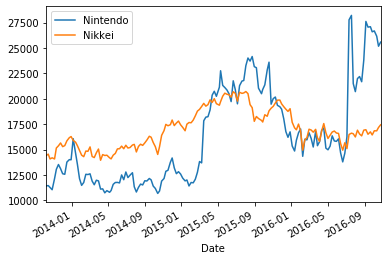

In [20]:
ax = nintendo.plot(y='Close', label='Nintendo')
nikkei.plot(y='Close', label='Nikkei', ax=ax)

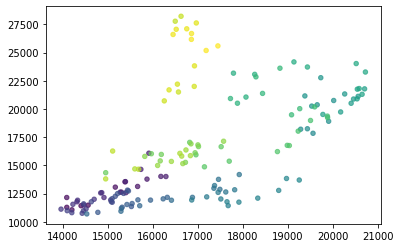

In [27]:
plt.scatter(nikkei.Close, nintendo.Close, s=20, c=range(len(nikkei)), cmap='viridis', alpha=0.7)

In [34]:
def scaler(s):
    return (s - s.mean()) / s.std()

## 時変係数モデル

In [92]:
endog, exog = scaler(nintendo.Close), scaler(nikkei.Close)

mod_reg = StateSpaceRegression(endog, exog, initialization='approximate_diffuse')
# mod_reg = StateSpaceRegression(endog, exog, initialization='approximate_dffuse',
#                               initial_state=np.zeros(2), initial_state_cov=np.array([[10, 0], [0, 10]]))

# mod_reg.ssm.transition
res_mod_reg = mod_reg.fit()
# res_mod_reg = mod_reg.fit(start_params=mod_reg.fit(method='newton').params)
res_mod_reg.summary()

/Users/yuho.kida/pyenv/tfp/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                    Close   No. Observations:                  160
Model:             StateSpaceRegression   Log Likelihood                 -18.105
Date:                  Tue, 03 Dec 2019   AIC                             42.210
Time:                          22:46:07   BIC                             51.397
Sample:                               0   HQIC                            45.941
                                  - 160                                         
Covariance Type:                    opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  3.843e-11      0.010   3.97e-09      1.000      -0.019       0.019
sigma2.intercept       0.0671      0.021      3.250      0.001       0.027       0.108
sigma2.coefficient     0.0017      0.002      0.721      0.471      -0.003       0.006
===================================================================================
Ljung-Box (Q):                       45.69   Jarque-Bera (JB):              3438.43
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              11.36   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

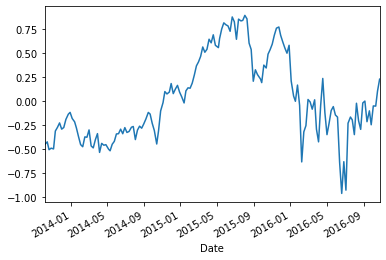

In [86]:
(res_mod_reg.smoothed_state[1] * exog).plot()

In [87]:
mu_smoothed, beta_smoothed = res_mod_reg.smoothed_state
mu_pred, beta_pred  = res_mod_reg.predicted_state

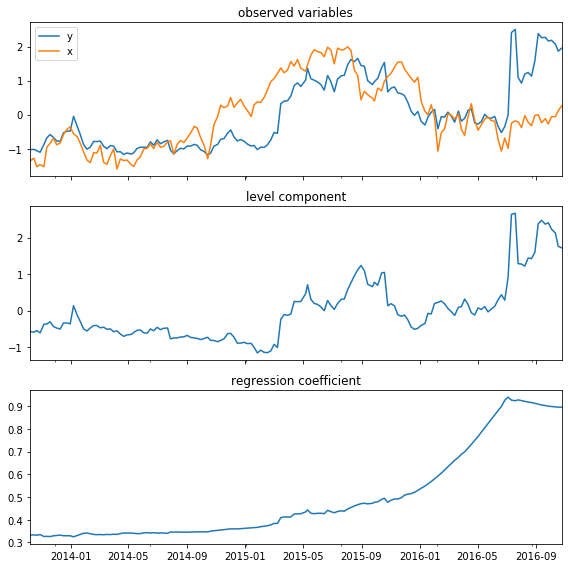

In [93]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
endog.plot(ax=axes[0], label='y')
exog.plot(ax=axes[0], label='x')
axes[0].set_title('observed variables')
axes[0].legend()

axes[1].plot(endog.index, mu_smoothed)
axes[1].set_title('level component')

axes[2].plot(endog.index, beta_smoothed)
axes[2].set_title('regression coefficient')

# axes[1].plot(endog.index, mu_pred[:-1])
# axes[2].plot(endog.index, beta_pred[:-1])

plt.tight_layout()
plt.savefig('nintendo.png')

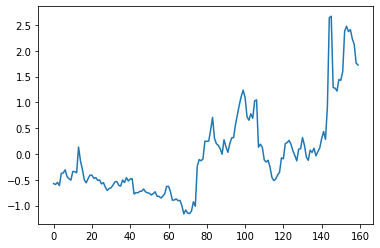

In [53]:
plt.plot()

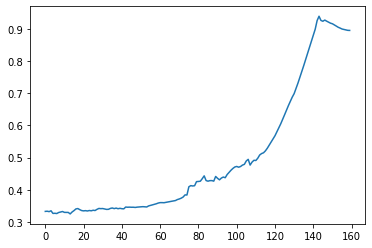

In [41]:
plt.plot(res_mod_reg.smoothed_state[1])

In [ ]:
plt.plot(nintendo.index, res_mod_reg.smoothed_state[1])
plt.fill_between(nintendo.index, 
                res_mod_reg.smoothed_state[1] - sig,
                res_mod_reg.smoothed_state[1] + sig, 
               alpha=0.2)

In [43]:
mod = sm.tsa.UnobservedComponents(endog, level='llevel', exog=exog, mle_regression=True)
res = mod.fit()
res.summary()

/Users/yuho.kida/pyenv/tfp/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Close   No. Observations:                  160
Model:                    local level   Log Likelihood                 -16.497
Date:                Tue, 03 Dec 2019   AIC                             38.994
Time:                        21:15:00   BIC                             48.201
Sample:                             0   HQIC                            42.733
                                - 160                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  3.363e-11      0.010   3.35e-09      1.000      -0.020       0.020
sigma2.level         0.0720      0.020      3.661      0.000       0.033       0.111
beta.Close           0.5375      0.109      4.941      0.000       0.324       0.751
===================================================================================
Ljung-Box (Q):                       51.53   Jarque-Bera (JB):              3869.74
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              10.39   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

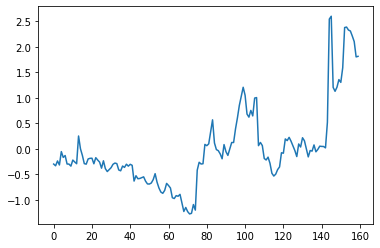

In [47]:
plt.plot(res.smoothed_state[0])

In [9]:
sales <- read.csv("data/sales.csv", encoding = "shift-jis")
Gasoline <- ts(scan("data/Gasoline.dat")) # ガソリン単価データの読み込み

NameError: name 'sales' is not defined

In [10]:
sig = np.sqrt(res_mod_reg.smoothed_state_cov[1, 1])

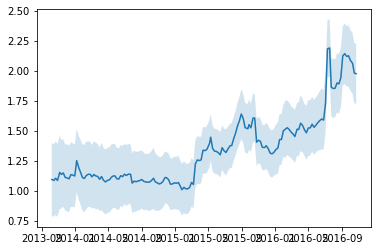

In [11]:
plt.plot(nintendo.index, res_mod_reg.smoothed_state[1])
plt.fill_between(nintendo.index, 
                res_mod_reg.smoothed_state[1] - sig,
                res_mod_reg.smoothed_state[1] + sig, 
               alpha=0.2)

In [12]:
pred = res_mod_reg.get_prediction()
pred.

SyntaxError: invalid syntax (<ipython-input-12-52b44ca7e158>, line 2)

In [ ]:
res_mod_reg = mod_reg.fit()

predict = res_mod_reg.get_prediction()

Z_new = np.vstack((np.repeat(1, n_forecast), np.arange(len(ts), len(ts) + n_forecast)))[np.newaxis, :, :]
forecast = res_mod_reg.forecast(steps=n_ahead, design=Z_new)

